## Perform standard imports

In [39]:
!pip install nltk fbprophet

In [191]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
from typing import Optional, Any, Union, Callable, Tuple
from pathlib import Path
import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load the dataset

In [192]:
df = pd.read_csv('/kaggle/input/glowbyte/train_dataset.csv',index_col=0,parse_dates=True)
df.head()

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [42]:
# seq_len = int(df['weather_pred'].str.split(', ').str.len().max())
# df['weather_pred_list'] = df['weather_pred'].str.split(', ')
# for i in range(1, seq_len + 1):
#     df[f'w_pred{i}'] = df['weather_pred_list'].str[i - 1]
# df.drop('weather_pred_list', axis=1, inplace=True)

# seq_len = int(df['weather_fact'].str.split(', ').str.len().max())
# df['weather_pred_list'] = df['weather_fact'].str.split(', ')
# for i in range(1, seq_len + 1):
#     df[f'w_fact{i}'] = df['weather_pred_list'].str[i - 1]
# df.drop('weather_pred_list', axis=1, inplace=True)
# df

In [43]:
df.head(25)

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,5,403.195,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,6,398.173,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"
2019-01-01,7,402.689,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"
2019-01-01,8,407.094,5.3,3.0,"пасм, ветер","ветер, пасм,дождь"


In [44]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse=False)
# encoded_data = encoder.fit_transform(df[['weather_fact']])
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['weather_fact']))
# df.reset_index(drop=True, inplace=True)
# encoded_df.reset_index(drop=True, inplace=True)
# df = pd.concat([df, encoded_df], axis=1)


In [193]:
seq_len = int(df['weather_pred'].str.split(', ').str.len().max())
df['weather_pred_list'] = df['weather_pred'].str.split(', ')
for i in range(1, seq_len + 1):
    df[f'w_pred{i}'] = df['weather_pred_list'].str[i - 1]
df.drop('weather_pred_list', axis=1, inplace=True)
df

,time,target,temp,temp_pred,weather_pred,weather_fact,w_pred1,w_pred2,w_pred3,w_pred4
date,,,,,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",пасм,ветер,NaN,NaN
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",пасм,ветер,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-03-31,19,552.960,7.9,6.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN
2023-03-31,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN
2023-03-31,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN


In [46]:
weather_mapping = {
    'дождь': 'дождь',
    'снег': 'снег',
    'гроза': 'гроза',
    'ветер': 'ветер',
    'пасмурно': 'пасмурно',
    'пасм' : 'пасмурно',
    'ясно': 'ясно',
    'облачно': 'облачно',
    'обл': 'облачно',
    'прояснения': 'ясно',
    'перем.обл.': 'облачно',
    'облч': 'облачно',
    'пасм,гроза': 'гроза',
    'ветрище': 'ветер',
    'солнечно': 'ясно',
    'дождь/снег': 'дождь',
    'неб облач': 'облачно',
    'пасм,15%': 'пасмурно',
    'пасм,23%': 'пасмурно',
    'пасм,12%': 'пасмурно',
    'пасм,14%': 'пасмурно',
    'пасм,17%': 'пасмурно',
    'пасм,9%': 'пасмурно',
    'пасм,42%': 'пасмурно',
    'пасм,78%': 'пасмурно',
    'пасм,73%': 'пасмурно',
    'пасм,47%': 'пасмурно',
    'пасм,11%': 'пасмурно',
    'пасм,37%': 'пасмурно',
    'пасм,24%': 'пасмурно',
    'пасм,30 %': 'пасмурно',
    'пасм,30%': 'пасмурно',
    'пасм,34%': 'пасмурно',
    'пасм,68%': 'пасмурно',
    'пасм,44%': 'пасмурно',
    'пасм,11%  д+снег': 'дождь',
    'пасм,17% снег': 'снег',
    'пасм,47% снег': 'снег',
    'пасм,24% ветер': 'ветер',
    'пасм,32% ветер': 'ветер',
    'пасм,12% ветер': 'ветер',
    'пасм.ветер': 'ветер',
    'пасм,78%,ветер': 'ветер',
    'пасм, 15%': 'пасмурно',
    'пасм,24%': 'пасмурно',
    'пасм,14% дождь': 'дождь',
    'пасм,78% д+сн': 'дождь',
    'пасм,34% дождь': 'дождь',
    'пасм,73% дождь': 'дождь',
    'пасм,47% дождь': 'дождь',
    'пасм,11% дождь': 'дождь',
    'пасм,37% дождь': 'дождь',
    'пасм,22% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,42% снег': 'снег',
    'пасм,12% снег': 'снег',
    'пасм,32% снег': 'снег',
    'пасм,16%': 'пасмурно',
    'пасм,9% дождь': 'дождь',
    'пасм,13% дождь': 'дождь',
    'пасм,22% дождь': 'дождь',
    'пасм,22% д+сн': 'дождь',
    'пасм,28% дождь': 'дождь',
    'пасм,31% дождь': 'дождь',
    'пасм,51% дождь': 'дождь',
    'пасм,18% дождь': 'дождь',
    'пасм,24% дождь': 'дождь',
    'пасм,14% дождь': 'дождь',
    'пасм,36% дождь': 'дождь',
    'пасм,15% снег': 'снег',
    'пасм,23% снег': 'снег',
    'пасм,12% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,17% снег': 'снег',
    'пасм,9% снег': 'снег',
    'пасм,42% снег': 'снег',
    'пасм,78% снег': 'снег',
    'пасм,73% снег': 'снег',
    'пасм,47% снег': 'снег',
    'пасм,11%  д+снег': 'дождь',
    'пасм,22% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,16% снег': 'снег',
    'пасм,34% снег': 'снег',
    'пасм,30 %': 'пасмурно',
    'пасм,30%': 'пасмурно',
    'пасм,34% дождь': 'дождь',
    'пасм,74%': 'пасмурно',
    'пасм ,ветер': 'ветер',
    'пасм,73%': 'пасмурно',
    'пасм,11%': 'пасмурно',
    'пасм,42%': 'пасмурно',
    'пасм.,снег': 'снег',
    'пасм.,снег/дождь': 'снег с дождем',
    'пасм.,дождь40%': 'дождь',
    'пасм.,дождь50%': 'дождь',
    'пасм.,дождь30%': 'дождь',
    'пасм.,дождь35%': 'дождь',
    'пасм.,дождь 58%': 'дождь',
    'пасм.,дождь 59%': 'дождь',
    'пасм.,возм.дождь': 'дождь',
    'пасм.,дождь35%': 'дождь',
    'пасм.,дождь53%': 'дождь',
    'пасм.,дождь 58%': 'дождь',
    'пасм.,дождь 59%': 'дождь',
    'пасм.,дождь 70%': 'дождь',
    'пасм.,дождь 70%': 'дождь',
    'пасм,23%': 'пасмурно',
    'пасм,12%': 'пасмурно',
    'пасм,14%': 'пасмурно',
    'пасм,17%': 'пасмурно',
    'пасм,42%': 'пасмурно',
    'пасм,15%': 'пасмурно',
    'пасм.,возм.сл.дождь': 'дождь',
    'пасм.,снег': 'снег',
    'пасм.,снег/дождь': 'снег с дождем',
    'пасм.,дождь40%': 'дождь',
    'пасм.,дождь50%': 'дождь',
    'пасм.,дождь30%': 'дождь',
    'пер.обл.,дождь': 'дождь',
    'п/обл.,дождь,гроза': 'гроза',
    'пер.обл.,дождь40%': 'дождь',
    'пер.обл.,дождь35%': 'дождь',
    'пер.обл.,дождь55%': 'дождь',
    'пер.обл.,дождь70%': 'дождь',
    'пер.обл.,дождь58%': 'дождь',
    'пер.обл.,дождь62%': 'дождь',
    'пер.обл.,дождь64%': 'дождь',
    'пер.обл.,дождь41%': 'дождь',
    'пер.обл.,дождь30%': 'дождь',
    'пер.обл.,дождь50%': 'дождь',
    'пер.обл.,дождь40%': 'дождь',
    'пер.обл.,дождь62%': 'дождь',
    'пер.обл.,дождь64%': 'дождь',
    'пер.обл.,дождь41%': 'дождь',
    'пер.обл.,дождь30%': 'дождь',
    'пер.обл.,ветер,дождь50%': 'ветер, дождь',
    'пер.обл.,ветер,дождь40%': 'ветер, дождь',
    'пер.обл.,возм.дождь': 'дождь',
    'пер.обл.,дождь': 'дождь',
    'пер.обл.,гроза 81%': 'гроза',
    'пер.обл.,гроза 88%': 'гроза',
    'пер.обл.,сл.дождь 61%': 'дождь',
    'пер.обл.,сл.дождь 64%': 'дождь',
    'пер.обл.,сл.дождь 91%': 'дождь',
    'пер.обл.,сл.дождь 81%': 'дождь',
    'пер.обл.,сл.дождь 70%': 'дождь',
    'пер.обл.,гроза 81%': 'гроза',
    'пер.обл.,гроза 88%': 'гроза',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.обл./сл.дождь 91%': 'дождь',
    'пер.обл./сл.дождь 81%': 'дождь',
    'пер.обл./сл.дождь 70%': 'дождь',
    'пер.обл./гроза 81%': 'гроза',
    'пер.обл./гроза 88%': 'гроза',
    'пер.обл./сл.дождь 61%': 'дождь',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.облачность': 'облачно',
    'перем.обл.': 'облачно',
    'перем.обл.': 'облачно',
    'пер.обл./лёгкий дождь': 'легкий дождь',
    'перем.обл.': 'облачно',
    'пер.обл./местами грозы': 'гроза',
    'переменная облачность': 'облачно',
    'пер.обл.ветер': 'ветер',
    'пер.облачн.': 'облачно',
    'пер.обл. / возм.дождь': 'дождь',
    'пер.обл.,возм.дождь': 'дождь',
    'пер.обл.,возм.сл.дождь': 'дождь',
    'пер.обл.,сл.дождь': 'дождь',
    'пер.обл': 'облачно',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.обл./сл.дождь 91%': 'дождь',
    'пер.обл./сл.дождь 81%': 'дождь',
    'пер.обл./сл.дождь 70%': 'дождь',
    'пер.обл./гроза 81%': 'гроза',
    'пер.обл./гроза 88%': 'гроза',
    'пер.обл./сл.дождь 61%': 'дождь',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.облачн.': 'облачно',
    'пер.обл. / возм.дождь': 'дождь',
    'пер.обл.,возм.дождь': 'дождь',
    'пер.обл.,возм.сл.дождь': 'дождь',
    'пер.обл.,сл.дождь': 'дождь',
    'пер.обл': 'облачно',
    'дождь 0,2мм 44%': 'дождь',
    'дождь 1,2': 'дождь',
    'дождь 2,8': 'дождь',
    'дождь 1,5': 'дождь',
    'дождь 52%': 'дождь',
    'дождь 61%': 'дождь',
    'дождь 85%': 'дождь',
    'дождь/снег': 'дождь',
    'дождь/снег,ветер!': 'дождь',
    'дождь/снег,ветер!': 'дождь',
    'дождь со снегом': 'дождь',
    'дождь': 'дождь',
    'дождь 1,2': 'дождь',
    'дождь 2,8': 'дождь',
    'дождь 1,5': 'дождь',
    'дождь 52%': 'дождь',
    'дождь 61%': 'дождь',
    'дождь 85%': 'дождь',
    'гроза': 'гроза',
    'неб.снег': 'снег',
    'снег': 'снег',
    'возм. снег': 'снег',
    'пасм,47% снег': 'снег',
    'пасм,11%  д+снег': 'дождь со снегом',
    'пасм,17% снег': 'снег',
    'пасм,24% ветер': 'ветер',
    'пасм,32% ветер': 'ветер',
    'пасм,12% ветер': 'ветер',
    'пасм.ветер': 'ветер',
    'пасм,78%,ветер': 'ветер',
    'пасм, 15%': 'пасмурно',
    'пасм,24%': 'пасмурно',
    'пасм,14% дождь': 'дождь',
    'пасм,78% д+сн': 'дождь',
    'пасм,34% дождь': 'дождь',
    'пасм,73% дождь': 'дождь',
    'пасм,47% дождь': 'дождь',
    'пасм,11% дождь': 'дождь',
    'пасм,37% дождь': 'дождь',
    'пасм,22% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,42% снег': 'снег',
    'пасм,12% снег': 'снег',
    'пасм,32% снег': 'снег',
    'пасм,16%': 'пасмурно',
    'пасм,9% дождь': 'дождь',
    'пасм,13% дождь': 'дождь',
    'пасм,22% дождь': 'дождь',
    'пасм,22% д+сн': 'дождь',
    'пасм,28% дождь': 'дождь',
    'пасм,31% дождь': 'дождь',
    'пасм,51% дождь': 'дождь',
    'пасм,18% дождь': 'дождь',
    'пасм,24% дождь': 'дождь',
    'пасм,14% дождь': 'дождь',
    'пасм,36% дождь': 'дождь',
    'пасм,15% снег': 'снег',
    'пасм,23% снег': 'снег',
    'пасм,12% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,17% снег': 'снег',
    'пасм,9% снег': 'снег',
    'пасм,42% снег': 'снег',
    'пасм,78% снег': 'снег',
    'пасм,73% снег': 'снег',
    'пасм,47% снег': 'снег',
    'пасм,11%  д+снег': 'дождь',
    'пасм,22% снег': 'снег',
    'пасм,14% снег': 'снег',
    'пасм,16% снег': 'снег',
    'пасм,34% снег': 'снег',
    'пасм,30 %': 'пасмурно',
    'пасм,30%': 'пасмурно',
    'пасм,34% дождь': 'дождь',
    'пасм,74%': 'пасмурно',
    'пасм ,ветер': 'ветер',
    'пасм,73%': 'пасмурно',
    'пасм,11%': 'пасмурно',
    'пасм,42%': 'пасмурно',
    'пасм.,снег': 'снег',
    'пасм.,снег/дождь': 'снег с дождем',
    'пасм.,дождь40%': 'дождь',
    'пасм.,дождь50%': 'дождь',
    'пасм.,дождь30%': 'дождь',
    'пасм.,дождь35%': 'дождь',
    'пасм.,дождь 58%': 'дождь',
    'пасм.,дождь 59%': 'дождь',
    'пасм.,возм.дождь': 'дождь',
    'пасм.,дождь35%': 'дождь',
    'пасм.,дождь53%': 'дождь',
    'пасм.,дождь 58%': 'дождь',
    'пасм.,дождь 59%': 'дождь',
    'пасм.,дождь 70%': 'дождь',
    'пасм.,дождь 70%': 'дождь',
    'пасм,23%': 'пасмурно',
    'пасм,12%': 'пасмурно',
    'пасм,14%': 'пасмурно',
    'пасм,17%': 'пасмурно',
    'пасм,42%': 'пасмурно',
    'пасм,15%': 'пасмурно',
    'пасм.,возм.сл.дождь': 'дождь',
    'пасм.,снег': 'снег',
    'пасм.,снег/дождь': 'снег',
    'пасм.,дождь40%': 'дождь',
    'пасм.,дождь50%': 'дождь',
    'пасм.,дождь30%': 'дождь',
    'пер.обл.,дождь': 'дождь',
    'п/обл.,дождь,гроза': 'гроза',
    'пер.обл.,дождь40%': 'дождь',
    'пер.обл.,дождь35%': 'дождь',
    'пер.обл.,дождь55%': 'дождь',
    'пер.обл.,дождь70%': 'дождь',
    'пер.обл.,дождь58%': 'дождь',
    'пер.обл.,дождь62%': 'дождь',
    'пер.обл.,дождь64%': 'дождь',
    'пер.обл.,дождь41%': 'дождь',
    'пер.обл.,дождь30%': 'дождь',
    'пер.обл.,дождь50%': 'дождь',
    'пер.обл.,дождь40%': 'дождь',
    'пер.обл.,дождь62%': 'дождь',
    'пер.обл.,дождь64%': 'дождь',
    'пер.обл.,дождь41%': 'дождь',
    'пер.обл.,дождь30%': 'дождь',
    'пер.обл.,ветер,дождь50%': 'дождь',
    'пер.обл.,ветер,дождь40%': 'дождь',
    'пер.обл.,возм.дождь': 'дождь',
    'пер.обл.,дождь': 'дождь',
    'пер.обл.,гроза 81%': 'гроза',
    'пер.обл.,гроза 88%': 'гроза',
    'пер.обл.,сл.дождь 61%': 'дождь',
    'пер.обл.,сл.дождь 64%': 'дождь',
    'пер.обл.,сл.дождь 91%': 'дождь',
    'пер.обл.,сл.дождь 81%': 'дождь',
    'пер.обл.,сл.дождь 70%': 'дождь',
    'пер.обл.,гроза 81%': 'гроза',
    'пер.обл.,гроза 88%': 'гроза',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.обл./сл.дождь 91%': 'дождь',
    'пер.обл./сл.дождь 81%': 'дождь',
    'пер.обл./сл.дождь 70%': 'дождь',
    'пер.обл./гроза 81%': 'гроза',
    'пер.обл./гроза 88%': 'гроза',
    'пер.обл./сл.дождь 61%': 'дождь',
    'пер.обл./сл.дождь 64%': 'дождь',
    'пер.обл.ветер': 'ветер',
    'пер.обл. / возм.дождь': 'дождь',
    'пер.обл.,возм.дождь': 'дождь',
    'пер.обл.,возм.сл.дождь': 'дождь',
    'пер.обл.,сл.дождь': 'дождь',
    'дождь 0,2мм 44%': 'дождь',
    'дождь 1,2': 'дождь',
    'дождь 2,8': 'дождь',
    'дождь 1,5': 'дождь',
    'дождь 52%': 'дождь',
    'дождь 61%': 'дождь',
    'дождь 85%': 'дождь',
    'дождь/снег': 'дождь',
    'дождь/снег,ветер!': 'дождь',
    'дождь/снег,ветер!': 'дождь',
    'дождь со снегом': 'дождь',
    'дождь': 'дождь',
    'дождь 1,2': 'дождь',
    'дождь 2,8': 'дождь',
    'дождь 1,5': 'дождь',
    'дождь 52%': 'дождь',
    'дождь 61%': 'дождь',
    'дождь 85%': 'дождь',
    'гроза': 'гроза',
    'неб.снег': 'снег',
    'снег': 'снег',
    'возм. снег': 'снег',
    'ветер': 'ветер',
    'пасм': 'пасмурно',
    'ясно': 'ясно',
    'дождь': 'дождь',
    'облачно': 'облачно',
    'малообл': 'облачно',
    'пасмурно': 'пасмурно',
    'снег': 'снег',
    'п/обл': 'облачно',
    'дымка': 'облачно',
    'переменная облачность': 'облачно',
    'малообл.': 'облачно',
    'туман': 'облачно',
    'ледяной туман': 'облачно',
    'пасм.': 'пасмурно',
    'пасм,': 'пасмурно',
    'обл.,морось': 'облачно',
    'дымка ': 'облачно',
    'пасм.,морось': 'пасмурно',
    'пасм.,дождик': 'пасмурно',
    'обл.,лед.ветер': 'облачно',
    'малооб.': 'облачно',
    'пасm,дождь+снег крупа': 'пасмурно',
    'гроза': 'гроза',
    'морось': 'дождь',
    'ливень': 'дождь',
    'гром': 'гроза',
    'кр ливень': 'дождь',
    'спл.обл.': 'облачно',
    'обл.,мест.дождь': 'дождь',
    'врем.дождь': 'дождь',
    'сплош.обл.': 'облачно',
    'малооблачно': 'облачно',
    'сплошн.обл.': 'облачно',
    'перем.обл.': 'облачно',
    'пасm,ливень': 'пасмурно',
    'крапает дождик': 'дождь',
    'вр.ливни': 'дождь',
    'ливни': 'дождь',
    'ливень,пасм': 'дождь',
    'град': 'дождь',
    'кр. ливень': 'дождь',
    'проясн': 'ясно',
    'ливень стеной': 'дождь',
    'пасм/ясно': 'пасмурно',
    'неб дождик': 'дождь',
    'дождик': 'дождь',
    'пасм с проясн': 'пасмурно',
    'пасм,морось': 'пасмурно',
    'дождь+снег': 'дождь',
    'мокр снег+дождь': 'дождь',
    'изморозь': 'дождь',
    'кр.дождь': 'дождь',
    'яснно': 'ясно',
    'дожь': 'дождь',
    'шторм': 'ветер',
    'снежок': 'снег',
    'снег+дождь': 'дождь',
    'мелкий град': 'дождь',
    'ливень со снегом': 'дождь',
    'на востоке град': 'дождь',
    'мест.грозы с ливнем': 'дождь',
    'кр.ливень 15 минут': 'дождь',
    'кр.ливень': 'дождь',
    'тучи': 'облачно',
    'обл. с проясн.': 'облачно',
    'обл.,слаб.дождь': 'дождь',
    'пер.обл.,мест.дождик': 'дождь',
    'пер.обл.,мест.сл.дождь': 'дождь',
    'слаб.дождь': 'дождь',
    'обл.с проясн.': 'облачно',
    'обл.с проясн': 'облачно',
    'обл.,мест.дождик': 'дождь',
    'пасm.,ливень': 'пасмурно',
    'пер.обл.,слаб.дождь': 'дождь',
    'пер.обл.,ливни': 'дождь',
    'обл.,врем.дождь': 'дождь',
    'слабый дождик': 'дождь',
    'п/обл.': 'облачно',
    'мест туман': 'облачно',
    'легкая дымка': 'облачно',
    'пасм морось': 'пасмурно',
    'д+снег': 'дождь',
    'моромь': 'дождь',
    'метель': 'дождь',
    'вр.снежная метель': 'дождь',
    'малобл': 'облачно',
    'обл.,туман': 'облачно',
    'сл. Снег': 'снег',
    'вр.снег': 'снег',
    'снегопад': 'снег',
    'малообл,дымка': 'облачно',
    'пасm.,сл.дождь': 'дождь',
    'пасm.,мест.дождь': 'дождь',
    'мест. дожди,грозы': 'дождь',
    'мест.дождь': 'дождь',
    'перообл.': 'облачно',
    'ливень 20 минут': 'дождь',
    'сухие грозы': 'гроза',
    'дождик слепой': 'дождь',
    'грозы': 'гроза',
    'моровь': 'дождь',
    'п/обл ветерок': 'облачно',
    'обл.,сл.дождь': 'дождь',
    'малообл.,дымка': 'облачно',
    'пасm.,туман': 'пасмурно',
    'пасm,вр. метель': 'пасмурно',
    'слаб.дождь со снегом': 'дождь',
    'морось/мокр.снег': 'дождь',
    'заморозки': 'дождь',
    None: '0',
    'снежная крупа': 'снег',
    'обл. с пр.': 'облачно',
    'пасm ,дождик': 'пасмурно',
    'пасm.,слаб.дождик': 'пасмурно',
    'обл. с  пр.': 'облачно',
    'жарко': 'ветер',
    'душно': 'ветер',
    'ливн.дождь': 'дождь',
    'слаб.ливн.дождь': 'дождь',
    'пер.обл.,кр.вр.дожди': 'облачно',
    'проясн.': 'ясно',
    'обл.с пр.': 'облачно',
    'ливень с 10.40': 'дождь',
    'мест.туман': 'облачно',
    'очень душно': 'ветер',
    'местами туман': 'облачно',
    'кр.вр. дожди': 'дождь',
    'кр.вр.дождь': 'дождь',
    'дымка (кр.вр.дождь)': 'пасмурно',
    'дымка  ': 'пасмурно',
    'сплошная облачность': 'облачно',
    'п/об': 'облачно',
    'пасm ,морось': 'пасмурно',
    'снежок небольшой': 'снег',
    'неб. снежок': 'снег',
    'слаб.снег': 'снег',
    'пасm ,дымка': 'пасмурно',
    'пам': 'пасмурно',
    'мокрый нег': 'дождь',
    'легк.снежок': 'снег',
    'слаб.морось': 'пасмурно',
    'пасмурн': 'пасмурно',
    'переменная облачность': 'облачно',
    'обл.,лед.ветер': 'облачно',
    'малооб.': 'облачно',
    'гроза': 'гроза',
    'спл.обл.': 'облачно',
    'сплош.обл.': 'облачно',
    'сплошн.обл.': 'облачно',
    'перем.обл.': 'облачно',
    'мест.грозы с ливнем': 'гроза',
    'пер.обл.,мест.дождик': 'дождь',
    'пер.обл.,мест.сл.дождь': 'дождь',
    'обл.,мест.дождик': 'дождь',
    'сл. Снег': 'снег',
    'перообл.': 'облачно',
    'обл.,сл.дождь': 'дождь',
    'снежная крупа': 'снег',
    'обл. с пр.': 'облачно',
    'обл. с  пр.': 'облачно',
    'пер.обл.,кр.вр.дожди': 'облачно',
    'обл.с пр.': 'облачно',
    'кр.вр. дожди': 'дождь',
    'сплошная облачность': 'облачно',
    'мокрый нег': 'дождь'
}


In [47]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

def classify_weather_condition(text, weather_dict):
    if pd.notna(text):
        text = str(text)
        tokens = word_tokenize(text, language='russian')
        tokens = [word for word in tokens if word.lower() not in stopwords.words('russian')]
        for token in tokens:
            if token in weather_dict:
                return weather_dict[token]
        return text
    return None

for col in df.iloc[:, 6:].columns:
    df[col] = df[col].apply(lambda x: classify_weather_condition(x, weather_mapping))

df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,time,target,temp,temp_pred,weather_pred,weather_fact,w_pred1,w_pred2,w_pred3,w_pred4
date,,,,,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,пасмурно,ветер,None,None
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,пасмурно,ветер,None,None
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,пасмурно,ветер,None,None
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",пасмурно,ветер,None,None
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",пасмурно,ветер,None,None
...,...,...,...,...,...,...,...,...,...,...
2023-03-31,19,552.960,7.9,6.0,"пасм, 61%","пасм, дымка",пасмурно,61%,None,None
2023-03-31,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка",пасмурно,61%,None,None
2023-03-31,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка",пасмурно,61%,None,None


## Plotting time series data

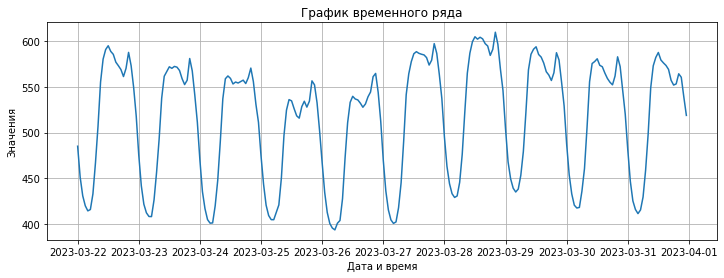

In [249]:
import matplotlib.dates as mdates
df['date'] = pd.to_datetime(df.index, format='%d.%m.%Y')
df['time'] = pd.to_timedelta(df['time'], unit='h')
df['ds'] = df['date'] + df['time']
df = df.drop(['date', 'time'], axis=1)
def plot_time_series(df, x_col, y_col, num_points=240, x_label='Дата и время', y_label='Значения', title='График временного ряда'):
    plt.figure(figsize=(12, 4))
    plt.plot(df[x_col][-num_points:], df[y_col][-num_points:])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()
plot_time_series(df, 'ds', 'target', num_points=240)


In [217]:
class PositionalEncoder(nn.Module):
    """
    Источник: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, dropout: float = 0.1, max_seq_len: int = 5000, d_model: int = 512):

        """
        Args:
            dropout: регуляризация
            max_seq_len: длина последовательности
            d_model: Размерность вывода подслоев в модели
        """
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_seq_len).unsqueeze(1)
        exp_input = torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        div_term = torch.exp(exp_input)
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Тензор, размерность [batch_size, enc_seq_len, dim_val]
        """

        add = self.pe[:x.size(1), :].squeeze(1)
        x = x + add

        return self.dropout(x)


In [218]:

class TimeSeriesTransformer(nn.Module):


    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        max_seq_len: int,
        out_seq_len: int=24,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        ): 

        """
        Args:
            input_size: int, количество входных переменных. 1, если одномерная последовательность.
             dec_seq_len: int, длина входной последовательности, подаваемой в декодер.
             max_seq_len: int, длина самой длинной последовательности, которую будет использовать модель.
             out_seq_len: int, длина выходных данных модели (т. е. целевая
                          длина последовательности)
             dim_val: int, он же d_model. Все подслои модели создают
                      выходные данные измерения dim_val
             n_encoder_layers: int, количество сложенных слоев кодера в енкодере.
             n_decoder_layers: int, количество сложенных слоев кодера в декодере.
             n_heads: int, количество attention heads (также известных как параллельные слои внимания)
             dropout_encoder: float, регуляризатор енкодера
             dropout_decoder: float, регуляризатор декодера
             dropout_pos_enc: float, регуляризатор позиционного энкодера
             dim_feedforward_encoder: int, количество нейронов в линейном слое енкодера
             dim_feedforward_decoder: int, количество нейронов в линейном слое декодера
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len
        print("input_size is: {}".format(input_size))
        print("dim_val is: {}".format(dim_val))
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )
        self.decoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )  
        self.linear_mapping = nn.Linear(
            in_features=out_seq_len*dim_val,
            out_features=out_seq_len
            )
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=max_seq_len
            )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=True
            )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=True
            )
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Args:
             src: выходная последовательность кодера. Форма: (S,E) для непакетированного ввода,
                  (S, N, E), если пакет_first=False, или (N, S, E), если пакет_first=True, 
                  где S — длина исходной последовательности, N — размер пакета, а E — номер функции.
             tgt: последовательность для декодера. Форма: (T,E) для непакетированного ввода, (T, N, E)(T,N,E), 
             если пакет_first=False или (N, T, E), если пакет_first=True, где T — длина целевой последовательности, 
             N — размер партии, E — номер функции.
             src_mask: маска для последовательности src, чтобы модель не могла использовать точки данных 
             из целевой последовательности.
             tgt_mask: маска для последовательности tgt, предотвращающая использование моделью точек данных 
             из целевой последовательности.
        """
        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        src = self.encoder(
            src=src
            )
        decoder_output = self.decoder_input_layer(tgt)
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )
        decoder_output= self.linear_mapping(decoder_output.flatten(start_dim=1))
        return decoder_output


In [219]:

class TransformerDataset(Dataset):
    """
    Класс набора данных, используемый для трансформеров.
    
    """
    def __init__(self, 
        data: torch.tensor,
        indices: list, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> None:

        """
        Args:
            data: тензор, весь train, последовательность проверочных или тестовых данных. Если одномерный, 
                data.size() будет [количество образцов, количество переменных], где количество переменных 
                будет равно 1 + количество экзогенные переменные. Количество экзогенных переменных будет 0 
                если последоватеьность одномерная.
             indices: список кортежей. Каждый кортеж состоит из двух элементов:
                      1) начальный индекс подпоследовательности
                      2) конечный индекс подпоследовательности.
                      Подпоследовательность позже разбивается на src, trg и trg_y.
             enc_seq_len: int, желаемая длина входной последовательности.
             target_seq_len: int, желаемая длина целевой последовательности (выходные данные модели)
             target_idx: позиция индекса целевой переменной в данных.
        """
        
        super().__init__()
        self.indices = indices
        self.data = data
        print("From get_src_trg: data size = {}".format(data.size()))
        self.enc_seq_len = enc_seq_len
        self.dec_seq_len = dec_seq_len
        self.target_seq_len = target_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        """
        Возвращает кортеж из трех элементов:
         1) src (вход энкодера)
         2) trg (вход декодера)
         3) trg_y (цель)
        """
        start_idx = self.indices[index][0]
        end_idx = self.indices[index][1]
        sequence = self.data[start_idx:end_idx]
        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            dec_seq_len=self.dec_seq_len,
            target_seq_len=self.target_seq_len
            )
        return src, trg, trg_y
    
    def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Ненерирует последовательности src (вход кодера), trg (вход декодера) и trg_y (цель).
        Args:
            sequence: тензор, одномерный тензор длины n, где n = входная длина кодера + длина целевой последовательности
            enc_seq_len: int, желаемая длина входа в энкодер трансформера
            target_seq_len: int, желаемая длина целевой последовательности (той, с которой сравниваются выходные данные модели)
        Return: 
            src: tensor, 1D
            trg: tensor, 1D
            trg_y: tensor, 1D
        
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        src = sequence[:enc_seq_len] 
        trg = sequence[enc_seq_len-1:len(sequence)-1]
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"
        trg_y = sequence[-target_seq_len:]
        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"
        
        return src, trg, trg_y.squeeze(-1) # reshape from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len]

In [220]:

def generate_square_subsequent_mask(dim1: int, dim2: int, dim3: int) -> Tensor:
    """
    Генерирует верхнетреугольную матрицу -inf заполненную нулями.
    Источник: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, batch_size * n_heads
        dim2: инт. Для маскировки src и trg это должна быть длина целевой последовательности.
        dim3: инт. Для маскировки src это должна быть длина последовательности кодера.
               Для маскировки trg это должна быть длина целевой последовательности.
    Return:
        Tensor of shape [dim1, dim2, dim3]
    """
    return torch.triu(torch.ones(dim1, dim2, dim3) * float('-inf'), diagonal=1)


In [221]:

def get_indices_input_target(num_obs, input_len, step_size, forecast_horizon, target_len):
        """
        Создаёт все начальные и конечные индексные позиции всех подпоследовательностей.
         Индексы будут использоваться для разделения данных на подпоследовательности, на которых
         модели будут обучены.
         Возвращает кортеж из четырех элементов:
         1) Индексная позиция первого элемента, который будет включен во входную последовательность.
         2) Индексная позиция последнего элемента, который будет включен во входную последовательность.
         3) Индексная позиция первого элемента, который будет включен в целевую последовательность.
         4) Индексная позиция последнего элемента, который будет включен в целевую последовательность.
        
        Args:
            num_obs (int): количество наблюдений во всем наборе данных, для которых необходимо создать индексы.
             input_len (int): длина входной последовательности (подпоследовательность всей последовательности данных)
             Step_size (int): Размер каждого шага при прохождении последовательности данных. 
                             Если 1, первая подпоследовательность будет иметь индекс 0-input_len, 
                             а следующая будет 1-input_len.
             forecast_horizon (int): На сколько позиций индекса цель находится дальше от последней позиции 
                                     индекса входной последовательности? Если forecast_horizon=1 и входная 
                                     последовательность — data[0:10], целью будет data[11:taget_len].
             target_len (int): длина целевой/выходной последовательности.
        """

        input_len = round(input_len) # just a precaution
        start_position = 0
        stop_position = num_obs-1 # because of 0 indexing
        subseq_first_idx = start_position
        subseq_last_idx = start_position + input_len
        target_first_idx = subseq_last_idx + forecast_horizon
        target_last_idx = target_first_idx + target_len 
        print("target_last_idx is {}".format(target_last_idx))
        print("stop_position is {}".format(stop_position))
        indices = []
        while target_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx, target_first_idx, target_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size
            target_first_idx = subseq_last_idx + forecast_horizon
            target_last_idx = target_first_idx + target_len

        return indices


In [222]:
def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:
        """
        Создаёт все начальные и конечные позиции индексов, необходимые для создания подпоследовательностей.
         Возвращает список кортежей. Каждый кортеж представляет собой (start_idx, end_idx) подпоследовательности. 
         Эти кортежи следует использовать для разделения набора данных на подпоследовательности. 
         Эти подпоследовательности затем следует передать в функцию, которая делит их на входную и целевую последовательности
        
        Args:
            num_obs (int): Количество наблюдений (time steps)
            window_size (int): (input_sequence_length + target_sequence_length)
            step_size (int): Размер каждого шага при прохождении последовательности данных window_size. 
                            Если 1, первая подпоследовательность будет [0:window_size], а следующая — [1:window_size].
        Return:
            indices: список кортежей
        """
        stop_position = len(data)-1 # 1- because of 0 indexing
        subseq_first_idx = 0
        subseq_last_idx = window_size
        indices = []
        while subseq_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size

        return indices

In [223]:

def read_data(data_dir: Union[str, Path] = "/kaggle/input/glowbyte/",  
    timestamp_col_name: str="date",norm: bool=True) -> pd.DataFrame:
    """
    Читает данные из csv и возвращает pd.Dataframe
    Args:
        data_dir: путь к директории, где находится файл
        timestamp_col_name: str, столбец временной шкалы
    """
    data_dir = Path(data_dir)
    csv_files = list(data_dir.glob("*.csv"))
    if len(csv_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")

    data_path = csv_files[0]
    print("Reading file in {}".format(data_path))
    df = pd.read_csv(
        data_path, 
        parse_dates=[timestamp_col_name], 
        index_col=[timestamp_col_name], 
        infer_datetime_format=True,
        low_memory=False
    )
    if is_ne_in_df(df):
        raise ValueError("DataFrame contains 'n/e' values. These must be handled")
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_timedelta(df['time'], unit='h')
    df['ds'] = df['date'] + df['time']
    df = df.drop(['date', 'time'], axis=1)
    df.rename(columns={'target': 'y'}, inplace=True)
    data = to_numeric_and_downcast_data(df)
    if norm == True:
        initialize_norm = standardize_data()
        data = initialize_norm.to_normalize(data)
    data.sort_values(by=['ds'], inplace=True)

    return initialize_norm, data


In [224]:
from sklearn.preprocessing import MinMaxScaler

class standardize_data:
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
    
    def to_normalize(self,data):
        data[['y']] = self.scaler.fit_transform(data[['y']].values)
        return data
    
    def to_reverse_normalization(self,data):
        data[['y']] = self.scaler.inverse_transform(data[['y']].values)
        return data
    

# class StandardizeData:
#     def __init__(self):
#         self.scalers = {}

#     def fit(self, data, feature):
#         scaler = MinMaxScaler(feature_range=(-1, 1))
#         scaler.fit(data[[feature]])
#         self.scalers[feature] = scaler

#     def transform(self, data, feature):
#         if feature not in self.scalers:
#             raise ValueError(f"Scaler for feature '{feature}' has not been fitted.")
#         data_copy = data.copy()
#         data_copy[[feature]] = self.scalers[feature].transform(data[[feature]])
#         return data_copy

#     def fit_transform(self, data, feature):
#         self.fit(data, feature)
#         return self.transform(data, feature)

#     def reverse_transform(self, data, feature):
#         if feature not in self.scalers:
#             raise ValueError(f"Scaler for feature '{feature}' has not been fitted.")
#         data_copy = data.copy()
#         data_copy[[feature]] = self.scalers[feature].inverse_transform(data[[feature]])
#         return data_copy


In [225]:

def is_ne_in_df(df:pd.DataFrame):
    for col in df.columns:
        true_bool = (df[col] == "n/e")
        if any(true_bool):
            return True
    return False

In [226]:

def to_numeric_and_downcast_data(df: pd.DataFrame):
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

In [227]:
def prepare_data(data,batch_size):
    data_indices = get_indices_entire_sequence(
        data=data, 
        window_size=window_size, 
        step_size=1)
    data1 = TransformerDataset(
        data=torch.tensor(data[input_variables].values).float(),
        indices=data_indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=dec_seq_len,
        target_seq_len=output_sequence_length
        )
    
    return DataLoader(data,batch_size)

# Set Model Params:

In [228]:
# Hyperparams

batch_size = 124
target_col_name = "target"
timestamp_col = "date"

# Params
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 30
enc_seq_len = 30
output_sequence_length = 24 # target sequence length.
window_size = enc_seq_len + output_sequence_length
step_size = 1
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len

# Input variables 
exogenous_vars = []
input_variables = ['y'] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y
input_size = len(input_variables)

test_size = 240
# Read data
norm, data = read_data(data_dir="/kaggle/input/glowbyte/Задание 1го этапа/train")

# Remove test data from dataset
training_data = data[:-test_size]
testing_data = data[-test_size:]

Reading file in /kaggle/input/glowbyte/Задание 1го этапа/train/train_dataset.csv


In [230]:
training_data = prepare_data(training_data,batch_size)
testing_data = prepare_data(testing_data,batch_size)

i, batch = next(enumerate(training_data))

src, trg, trg_y = batch

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads).to(device)

criterion = nn.MSELoss()
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100
best_model = None

From get_src_trg: data size = torch.Size([36984, 1])
From get_src_trg: data size = torch.Size([240, 1])
input_size is: 1
dim_val is: 512


In [66]:
best_valloss = torch.tensor(float('inf')).to(device)
patience, trials = 100, 0
import time
start_time = time.time()

for epoch in range(epochs):
    for i, batch in enumerate(training_data):
        src, trg, y_train = batch
        src = src.to(device)
        trg = trg.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        batch_size = src.shape[0]
        src_mask = generate_square_subsequent_mask(
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=enc_seq_len
                                            ).to(device)
        tgt_mask = generate_square_subsequent_mask( 
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=output_sequence_length
                                            ).to(device)

        y_pred = model(
                    src=src,
                    tgt=trg,
                    src_mask=src_mask,
                    tgt_mask=tgt_mask
                    )
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    model.eval() 
    preds = torch.tensor([]).to(device)
    truth = torch.tensor([]).to(device)
    for i, batch in enumerate(testing_data):
        src, trg, y_test = batch
        src = src.to(device)
        trg = trg.to(device)
        y_test = y_test.to(device)
        batch_size = src.shape[0]
        src_mask = generate_square_subsequent_mask(
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=enc_seq_len
                                            ).to(device)
        tgt_mask = generate_square_subsequent_mask( 
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=output_sequence_length
                                            ).to(device)
        with torch.no_grad():
            y_pred = model(
                        src=src,
                        tgt=trg,
                        src_mask=src_mask,
                        tgt_mask=tgt_mask
                        )
            preds = torch.cat((preds,y_pred[:,-1:].reshape(1,-1)[0]))
            truth = torch.cat((truth,y_test[:,-1:].reshape(1,-1)[0]))

    val_loss = criterion(preds, truth)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. train-Loss: {loss.item():.6f}. Val-Loss.: {val_loss.item():.6f}')

    if val_loss < best_valloss:
        trials = 0
        best_valloss = val_loss
        torch.save(model.state_dict(), './VT-Tranformer-normalized-data-best.pth')
        print(f'Epoch {epoch} best model saved with val-loss: {best_valloss.item():.6f}, train-loss: {loss.item():.6f}.')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:   0. train-Loss: 0.038408. Val-Loss.: 0.006642
Epoch 0 best model saved with val-loss: 0.006642, train-loss: 0.038408.
Epoch:  1 Loss: 0.03840804
Epoch:  2 Loss: 0.02352826
Epoch:  3 Loss: 0.01325552
Epoch:  4 Loss: 0.00790203
Epoch:  5 Loss: 0.00997544
Epoch:   5. train-Loss: 0.007474. Val-Loss.: 0.007635
Epoch:  6 Loss: 0.00747377
Epoch:  7 Loss: 0.00691248
Epoch 7 best model saved with val-loss: 0.005314, train-loss: 0.007186.
Epoch:  8 Loss: 0.00718581
Epoch:  9 Loss: 0.01126805
Epoch: 10 Loss: 0.00750197
Epoch:  10. train-Loss: 0.010367. Val-Loss.: 0.013512
Epoch: 11 Loss: 0.01036668
Epoch 11 best model saved with val-loss: 0.003634, train-loss: 0.006467.
Epoch: 12 Loss: 0.00646653
Epoch: 13 Loss: 0.00830335
Epoch: 14 Loss: 0.00970970
Epoch: 15 Loss: 0.00482479
Epoch:  15. train-Loss: 0.012271. Val-Loss.: 0.002509
Epoch 15 best model saved with val-loss: 0.002509, train-loss: 0.012271.
Epoch: 16 Loss: 0.01227143
Epoch: 17 Loss: 0.00228845
Epoch: 18 Loss: 0.00171095
Epoch: 1

In [90]:
torch.cuda.empty_cache()

In [177]:
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads).to(device)

input_size is: 1
dim_val is: 512


In [231]:
model.load_state_dict(torch.load('/kaggle/input/models-glow/VT-Tranformer-normalized-data-best (1).pth'))

<All keys matched successfully>

In [234]:
# Load model to cuda
model.to(device)

In [244]:
preds = torch.tensor([]).to(device)
truth = torch.tensor([]).to(device)

for i, batch in enumerate(testing_data):
    src, trg, y_test = batch
    src = src.to(device)
    trg = trg.to(device)
    y_test = y_test.to(device)
    batch_size = src.shape[0]
    
    src_mask = generate_square_subsequent_mask(
                                        dim1=batch_size*n_heads,
                                        dim2=output_sequence_length,
                                        dim3=enc_seq_len
                                        ).to(device)
    tgt_mask = generate_square_subsequent_mask( 
                                        dim1=batch_size*n_heads,
                                        dim2=output_sequence_length,
                                        dim3=output_sequence_length
                                        ).to(device)
    with torch.no_grad():
        y_pred = model(
                    src=src,
                    tgt=trg,
                    src_mask=src_mask,
                    tgt_mask=tgt_mask
                    ).to(device)

        preds = torch.cat((preds,y_pred[:,-1:].reshape(1,-1)[0]))
        truth = torch.cat((truth,y_test[:,-1:].reshape(1,-1)[0]))

preds = preds.to(torch.device('cpu'))
truth = truth.to(torch.device('cpu'))
loss = criterion(preds, truth)

preds = norm.to_reverse_normalization(pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y']))
truth = norm.to_reverse_normalization(pd.DataFrame(truth.detach().numpy().reshape(-1,1),columns=['y']))

In [245]:
len(truth)

186

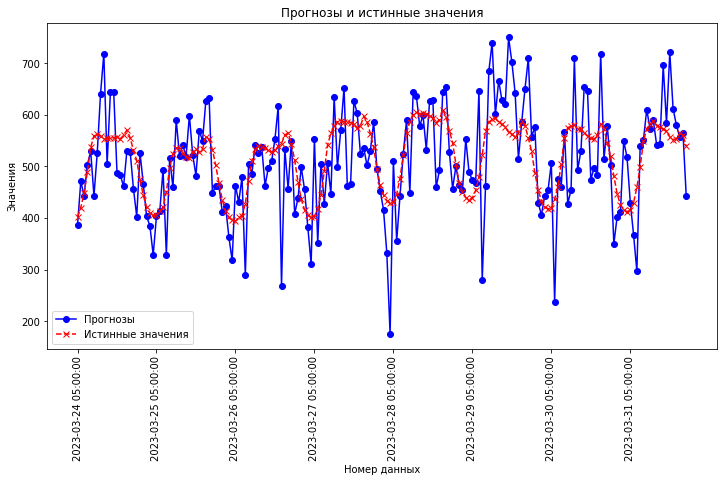

In [253]:
data_points = range(len(preds))
plt.figure(figsize=(12, 6))
plt.plot(data_points, preds, label='Прогнозы', marker='o', linestyle='-', color='b')
plt.plot(data_points, truth, label='Истинные значения', marker='x', linestyle='--', color='r')
plt.xticks(data_points[::24], df[-187:][:-1]['ds'][::24], rotation=90)
plt.legend()
plt.xlabel('Номер данных')
plt.ylabel('Значения')
plt.title('Прогнозы и истинные значения')
plt.show()


In [257]:
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2_scr = r2_score(y_true, y_pred)
    print("MSE: %.2f" % mse)
    print("MAE: %.2f" % mae)
    print("MAPE: %.2f" % mape)
    print("R2_score: %.2f" % r2_scr)
    
get_metrics(preds, truth)

MSE: 6394.90
MAE: 61.62
MAPE: 0.14
R2_score: 0.39


In [275]:
df.reset_index()['ds'][-187:][:-1]

,target,temp,temp_pred,weather_pred,weather_fact,w_pred1,w_pred2,w_pred3,w_pred4,ds
date,,,,,,,,,,
2019-01-01,481.510,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN,2019-01-01 00:00:00
2019-01-01,462.872,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN,2019-01-01 01:00:00
2019-01-01,449.718,2.9,2.0,"пасм, ветер",ветер,пасм,ветер,NaN,NaN,2019-01-01 02:00:00
2019-01-01,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",пасм,ветер,NaN,NaN,2019-01-01 03:00:00
2019-01-01,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",пасм,ветер,NaN,NaN,2019-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
2023-03-31,552.960,7.9,6.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN,2023-03-31 19:00:00
2023-03-31,563.985,7.9,6.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN,2023-03-31 20:00:00
2023-03-31,560.191,6.3,5.0,"пасм, 61%","пасм, дымка",пасм,61%,NaN,NaN,2023-03-31 21:00:00


In [283]:
test_data = pd.DataFrame()
test_data['Timestamp'] = df[-187:][:-1].reset_index(drop=True)['ds']
test_data['Original'] = df[-187:][:-1].reset_index(drop=True)['target']
test_data['Transformers_pred'] = preds['y']
test_data

,Timestamp,Original,Transformers_pred
0,2023-03-24 05:00:00,401.555,385.539825
1,2023-03-24 06:00:00,420.134,470.901093
2,2023-03-24 07:00:00,447.860,442.748169
3,2023-03-24 08:00:00,489.652,503.039459
4,2023-03-24 09:00:00,536.644,528.996643
...,...,...,...
181,2023-03-31 18:00:00,551.712,611.785156
182,2023-03-31 19:00:00,552.960,580.252319
183,2023-03-31 20:00:00,563.985,556.495605
184,2023-03-31 21:00:00,560.191,565.490601


In [290]:
norm, test = read_data(data_dir="/kaggle/input/glowbyte/Задание 1го этапа/test")
# testing_data = test
# testing_data = prepare_data(testing_data,batch_size)

Reading file in /kaggle/input/glowbyte/Задание 1го этапа/test/test_dataset.csv
From get_src_trg: data size = torch.Size([2928, 1])


In [300]:
test

,y,temp,temp_pred,weather_pred,weather_fact,ds
0,0.251772,5.700000,5.0,"пасм, 58%","пасм, морось",2023-04-01 00:00:00
1,0.052738,5.700000,5.0,"пасм, 58%","пасм, морось",2023-04-01 01:00:00
2,-0.069583,5.700000,5.0,"пасм, 58%","пасм, морось",2023-04-01 02:00:00
3,-0.130046,5.000000,4.0,"пасм, 71% дождь","пасм, дымка",2023-04-01 03:00:00
4,-0.163433,5.000000,4.0,"пасм, 71% дождь","пасм, дымка",2023-04-01 04:00:00
...,...,...,...,...,...,...
2923,0.099380,17.200001,18.0,"пасм, 24% дождь",п/обл,2023-07-31 19:00:00
2924,0.059188,17.200001,18.0,"пасм, 24% дождь",п/обл,2023-07-31 20:00:00
2925,0.048016,15.800000,17.0,"пасм, 24% дождь",п/обл,2023-07-31 21:00:00
2926,0.075478,15.800000,17.0,"пасм, 24% дождь",п/обл,2023-07-31 22:00:00


In [314]:
df = pd.read_csv('/kaggle/input/glowbyte/Задание 1го этапа/test/test_dataset.csv',index_col=0,parse_dates=True)
df['date'] = pd.to_datetime(df.index, format='%d.%m.%Y')
df['time'] = pd.to_timedelta(df['time'], unit='h')
df['ds'] = df['date'] + df['time']
df['y'] = df['target']
df = df.drop(['date', 'time', 'target'], axis=1)

x = np.arange('2023-08-01 00:00:00', '2023-08-02 00:00:00', dtype='datetime64[h]').astype('datetime64[h]')
arr = np.array([None]*len(x))
my_arr = []
for k, v in zip(x, arr):
    my_arr.append([k, v])

df2 = pd.DataFrame(my_arr, columns=['ds','y'])
df = df.reset_index().append(df2)
df = df.set_index('ds')
df

,date,temp,temp_pred,weather_pred,weather_fact,y
ds,,,,,,
2023-04-01 00:00:00,2023-04-01,5.7,5.0,"пасм, 58%","пасм, морось",479.282
2023-04-01 01:00:00,2023-04-01,5.7,5.0,"пасм, 58%","пасм, морось",445.182
2023-04-01 02:00:00,2023-04-01,5.7,5.0,"пасм, 58%","пасм, морось",424.225
2023-04-01 03:00:00,2023-04-01,5.0,4.0,"пасм, 71% дождь","пасм, дымка",413.866
2023-04-01 04:00:00,2023-04-01,5.0,4.0,"пасм, 71% дождь","пасм, дымка",408.146
...,...,...,...,...,...,...
2023-08-01 19:00:00,NaT,NaN,NaN,NaN,NaN,NaN
2023-08-01 20:00:00,NaT,NaN,NaN,NaN,NaN,NaN
2023-08-01 21:00:00,NaT,NaN,NaN,NaN,NaN,NaN


In [340]:
batch_size = 1

22

In [344]:
# 110 is the future unknown values

batch_size = 124
for i in range(0,124):
    df1 = df[-36-len(x)+i:-len(x)+i].copy()
    initialize_norm =  standardize_data()
    df1 = initialize_norm.to_normalize(df1)
    data_dl = prepare_data(df1, batch_size)
    
    
    
    preds = torch.tensor([]).to(device)
#     truth = torch.tensor([]).to(device)

    # extract the sequence & label from the training data
    for j, batch in enumerate(data_dl):
        src, trg, y_test = batch
        src, trg = src.reshape(1,30,1), trg.reshape(1,5,1)
        src = src.to(device)
        trg = trg.to(device)
        y_test = y_test.to(device)
        batch_size = src.shape[0]
        src_mask = generate_square_subsequent_mask(
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=enc_seq_len
                                            ).to(device)
        tgt_mask = generate_square_subsequent_mask( 
                                            dim1=batch_size*n_heads,
                                            dim2=output_sequence_length,
                                            dim3=output_sequence_length
                                            ).to(device)
        with torch.no_grad():
            y_pred = model(
                        src=src,
                        tgt=trg,
                        src_mask=src_mask,
                        tgt_mask=tgt_mask
                        ).to(device)

            preds = torch.cat((preds,y_pred[:,-1:].reshape(1,-1)[0]))
#             truth = torch.cat((truth,y_test[:,-1:].reshape(1,-1)[0]))
            preds = preds.to(torch.device('cpu'))
    preds = preds.to(torch.device('cpu'))
    
#     preds = to_reverse_normalization(preds)
    preds = initialize_norm.to_reverse_normalization(pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y']))
#     preds = norm.to_reverse_normalization(pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y']))
#     truth = norm.to_reverse_normalization(pd.DataFrame(truth.detach().numpy().reshape(-1,1),columns=['y']))
    df.iloc[-len(x)+i] = float(preds['y'][0])
    
    
# preds = norm.to_reverse_normalization(pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y']))
# truth = norm.to_reverse_normalization(pd.DataFrame(truth.detach().numpy().reshape(-1,1),columns=['y']))

From get_src_trg: data size = torch.Size([36, 1])


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [342]:
df1

,date,temp,temp_pred,weather_pred,weather_fact,y
ds,,,,,,
2023-07-30 12:00:00,2023-07-30,23.0,19.0,"пасм, 71% дождь",п/обл,0.698601
2023-07-30 13:00:00,2023-07-30,23.0,19.0,"пасм, 71% дождь",п/обл,0.681596
2023-07-30 14:00:00,2023-07-30,23.0,19.0,"пасм, 71% дождь",п/обл,0.663419
2023-07-30 15:00:00,2023-07-30,22.5,20.0,"пасм, 49% дождь",п/обл,0.640182
2023-07-30 16:00:00,2023-07-30,22.5,20.0,"пасм, 49% дождь",п/обл,0.612434
2023-07-30 17:00:00,2023-07-30,22.5,20.0,"пасм, 49% дождь",п/обл,0.573459
2023-07-30 18:00:00,2023-07-30,19.7,18.0,ясно,п/обл,0.585383
2023-07-30 19:00:00,2023-07-30,19.7,18.0,ясно,п/обл,0.544883
2023-07-30 20:00:00,2023-07-30,19.7,18.0,ясно,п/обл,0.485411


In [321]:
pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y'])

,y


In [299]:
preds = torch.tensor([]).to(device)
for i, batch in enumerate(testing_data):
    src, trg, y_test = batch
    src = src.to(device)
    trg = trg.to(device)
    y_test = y_test.to(device)
    batch_size = src.shape[0]
    
    src_mask = generate_square_subsequent_mask(
                                        dim1=batch_size*n_heads,
                                        dim2=output_sequence_length,
                                        dim3=enc_seq_len
                                        ).to(device)
    tgt_mask = generate_square_subsequent_mask( 
                                        dim1=batch_size*n_heads,
                                        dim2=output_sequence_length,
                                        dim3=output_sequence_length
                                        ).to(device)
    with torch.no_grad():
        y_pred = model(
                    src=src,
                    tgt=trg,
                    src_mask=src_mask,
                    tgt_mask=tgt_mask
                    ).to(device)

        preds = torch.cat((preds,y_pred[:,-1:].reshape(1,-1)[0]))

preds = preds.to(torch.device('cpu'))

preds = norm.to_reverse_normalization(pd.DataFrame(preds.detach().numpy().reshape(-1,1),columns=['y']))


ValueError: not enough values to unpack (expected 3, got 1)

In [294]:
preds

,y
0,483.429565
1,408.969025
2,511.303223
3,518.585022
4,502.037903
...,...
2869,451.803162
2870,456.237976
2871,480.464661
2872,417.486603


In [147]:
test = test[['ds', 'y']]


,ds,y
2737,2023-07-24 01:00:00,-0.574569
2738,2023-07-24 02:00:00,-0.706399
2739,2023-07-24 03:00:00,-0.777129
2740,2023-07-24 04:00:00,-0.809879
2741,2023-07-24 05:00:00,-0.859497


In [166]:
from fbprophet import Prophet
m = Prophet()
m.fit(df_p_train)
future = m.make_future_dataframe(periods=24,freq='H')
prophet_pred = m.predict(future)
test_data["Prophet_Predictions"] = prophet_pred['yhat'].values
test_data

Initial log joint probability = -287.046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5024.22     0.0114259        217.78      0.8379      0.8379      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5042.11    0.00395412       145.179      0.4173      0.4173      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       5042.94   0.000185813       96.3139    1.43e-06       0.001      296  LS failed, Hessian reset 
     299        5047.8    0.00122429       68.3976           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5054.88    0.00892041       163.668           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5059.92   0.000317041    

ValueError: Length of values (2766) does not match length of index (186)

In [165]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-01 00:00:00,0.582228,0.375549,0.613808,0.582228,0.582228,-0.091943,-0.091943,-0.091943,-0.097006,-0.097006,-0.097006,0.005063,0.005063,0.005063,0.0,0.0,0.0,0.490285
1,2023-04-01 01:00:00,0.580982,0.170626,0.394937,0.580982,0.580982,-0.295845,-0.295845,-0.295845,-0.296919,-0.296919,-0.296919,0.001075,0.001075,0.001075,0.0,0.0,0.0,0.285137
2,2023-04-01 02:00:00,0.579736,0.022434,0.247601,0.579736,0.579736,-0.449059,-0.449059,-0.449059,-0.445949,-0.445949,-0.445949,-0.003110,-0.003110,-0.003110,0.0,0.0,0.0,0.130677
3,2023-04-01 03:00:00,0.578490,-0.082276,0.153572,0.578490,0.578490,-0.543813,-0.543813,-0.543813,-0.536330,-0.536330,-0.536330,-0.007483,-0.007483,-0.007483,0.0,0.0,0.0,0.034676
4,2023-04-01 04:00:00,0.577243,-0.139910,0.092823,0.577243,0.577243,-0.598927,-0.598927,-0.598927,-0.586893,-0.586893,-0.586893,-0.012033,-0.012033,-0.012033,0.0,0.0,0.0,-0.021683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,2023-08-13 01:00:00,-0.189941,-0.744726,-0.437993,-0.282002,-0.091106,-0.406174,-0.406174,-0.406174,-0.296919,-0.296919,-0.296919,-0.109254,-0.109254,-0.109254,0.0,0.0,0.0,-0.596115
3218,2023-08-13 02:00:00,-0.189900,-0.894680,-0.596268,-0.282175,-0.090775,-0.557616,-0.557616,-0.557616,-0.445949,-0.445949,-0.445949,-0.111668,-0.111668,-0.111668,0.0,0.0,0.0,-0.747516
3219,2023-08-13 03:00:00,-0.189859,-0.991017,-0.686402,-0.282574,-0.090443,-0.650021,-0.650021,-0.650021,-0.536330,-0.536330,-0.536330,-0.113691,-0.113691,-0.113691,0.0,0.0,0.0,-0.839880
3220,2023-08-13 04:00:00,-0.189818,-1.047842,-0.741699,-0.283184,-0.090112,-0.702203,-0.702203,-0.702203,-0.586893,-0.586893,-0.586893,-0.115310,-0.115310,-0.115310,0.0,0.0,0.0,-0.892021


In [ ]:
y_p_pred = forecast[:-test_size]['ds'].values.astype(float)
y_p_true = df_p_train['y'].values.astype(float)
loss = criterion(torch.tensor(y_p_pred), torch.tensor(y_p_true))
loss

In [ ]:
y_p_pred = forecast[-test_size:]['ds'].values.astype(float)
y_p_true = df_p_test['y'].values.astype(float)
loss = criterion(torch.tensor(y_p_pred), torch.tensor(y_p_true))
loss

In [ ]:
fbprophet_predsv1 = y_p_pred

In [ ]:
y_p_pred

In [ ]:
# LSTM
y = df['y'].values.astype(float)
train_set = y[:-test_size]
test_set = y[-test_size:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
test_norm = scaler.fit_transform(test_set.reshape(-1, 1))

In [ ]:
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)
window_size = 30
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
test_data = input_data(test_norm,window_size)

len(train_data), len(test_data)

In [ ]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [ ]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

In [ ]:
epochs = 100
trials, patience = 0.0, 100
import time
start_time = time.time()
for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    model.eval() 
    preds =[]
    truth = []
    for seq, y_test in test_data:
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            truth.append(y_test.item())
    val_loss = criterion(y_pred, y_test)
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. train-Loss: {loss.item():.6f}. Val-Loss.: {val_loss.item():.6f}')
    if val_loss < best_valloss:
        trials = 0
        best_valloss = val_loss
        torch.save(model.state_dict(), './VT-LSTM-normalized-data-best-v1.pth')
        print(f'Epoch {epoch} best model saved with val-loss: {best_valloss.item():.6f}, train-loss: {loss.item():.6f}.')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [ ]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('./VT-LSTM-normalized-data-best-v1.pth'))
model.to(torch.device('cpu'))

In [ ]:
lstm_predsv1 = []
model.eval()
for seq, y_test in test_data:
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        lstm_predsv1.append(model(seq).item())


In [ ]:
lstm_prdsv1 = scaler.inverse_transform(np.array(lstm_predsv1).reshape(-1, 1))

In [ ]:
epochs = 25
model.train()
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)
start_time = time.time()
for epoch in range(epochs):
    for seq, y_train in all_data:  
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:
        torch.save(model.state_dict(), './VT-LSTM-best.pth')
        print(f'Epoch {epoch} model saved with train-loss: {loss.item():.6f}.')
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [ ]:
torch.manual_seed(101)
model = LSTMnetwork()

model.load_state_dict(torch.load('./VT-LSTM-best.pth'))

model.to(torch.device('cpu'))

In [ ]:
window_size = 24
future = 24
L = len(y)

lstm_predsv2 = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(lstm_predsv2[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        lstm_predsv2.append(model(seq).item())

lstm_predsv2 = scaler.inverse_transform(np.array(lstm_predsv2).reshape(-1, 1))

lstm_predsv2 = lstm_predsv2[window_size:]

In [ ]:
# prophet_pred = pd.DataFrame({"Date" : prophet_pred[-test_size:]['ds'], "Pred" : prophet_pred[-test_size:]["yhat"]})
# prophet_pred = prophet_pred.set_index("Date")
# prophet_pred.index.freq = "H"
# test_data["Prophet_Predictions"] = preds['Pred'].values
# prophet_pred